
# Cybersecurity: Suspicious Web Threat Interactions — End‑to‑End Notebook

This notebook loads a web-traffic CSV (AWS CloudWatch style), performs cleaning, EDA, feature engineering, and runs:
- **Unsupervised anomaly detection** (Isolation Forest)
- **Optional supervised classification** (RandomForest) if a label proxy exists

> Set `DATA_PATH` in the next cell before running.


In [10]:

# --- Config ---
DATA_PATH = "../data/CloudWatch_Traffic_Web_Attack.csv"


# --- Imports ---
import os, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Create outputs folder (relative to this notebook's location)
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

print("Using DATA_PATH =", DATA_PATH)


Using DATA_PATH = ../data/CloudWatch_Traffic_Web_Attack.csv


In [6]:

# --- Load dataset & first look ---
df = pd.read_csv(DATA_PATH)
print("Rows, Cols:", df.shape)
display(df.head(3))
print("\nColumns:", list(df.columns))

print("\nInfo:")
display(df.info())


Rows, Cols: (282, 16)


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule



Columns: ['bytes_in', 'bytes_out', 'creation_time', 'end_time', 'src_ip', 'src_ip_country_code', 'protocol', 'response.code', 'dst_port', 'dst_ip', 'rule_names', 'observation_name', 'source.meta', 'source.name', 'time', 'detection_types']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observ

None

In [13]:

# --- Cleaning & dtype fixes ---
df = df.copy()

# Drop duplicates if any
before = len(df)
df.drop_duplicates(inplace=True)
after = len(df)
print(f"Removed {before - after} duplicate rows.")

# Parse times if present
for col in ["creation_time", "end_time", "time"]:
    if col in df.columns:
        try:
            df[col] = pd.to_datetime(df[col], utc=True, errors="coerce")
        except Exception as e:
            print(f"Warning: could not convert {col} to datetime: {e}")

# Standardize country codes if present
if "src_ip_country_code" in df.columns and df["src_ip_country_code"].dtype == object:
    df["src_ip_country_code"] = df["src_ip_country_code"].astype(str).str.upper().str.strip()

# Report missingness
na = df.isna().sum().sort_values(ascending=False)
print("Missing values by column:")
display(na[na>0])

# Fill numeric missing values (conservative: median) for core numeric columns if present
for col in ["bytes_in", "bytes_out"]:
    if col in df.columns and df[col].dtype != object:
        df[col] = df[col].fillna(df[col].median())

# Drop rows with missing essential IDs if both exist
essential = [c for c in ["src_ip", "dst_ip"] if c in df.columns]
if essential:
    df.dropna(subset=essential, inplace=True)
print("Rows, Cols after cleaning:", df.shape)


Removed 0 duplicate rows.
Missing values by column:


Series([], dtype: int64)

Rows, Cols after cleaning: (282, 16)


## Exploratory Data Analysis (EDA)

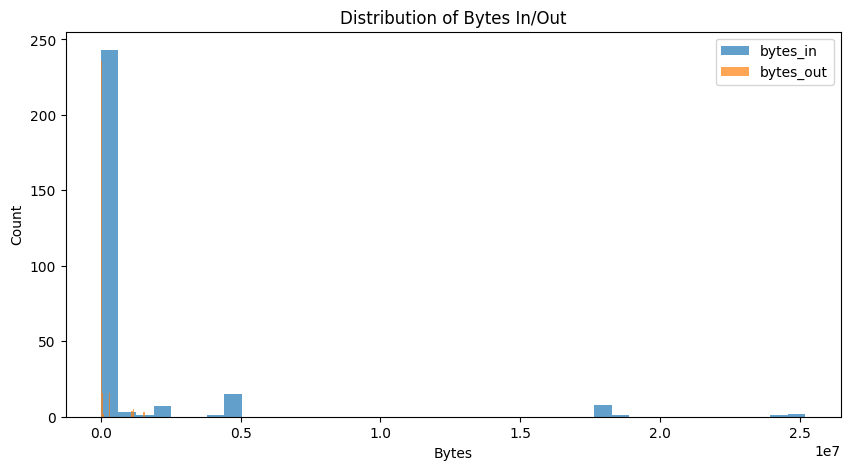

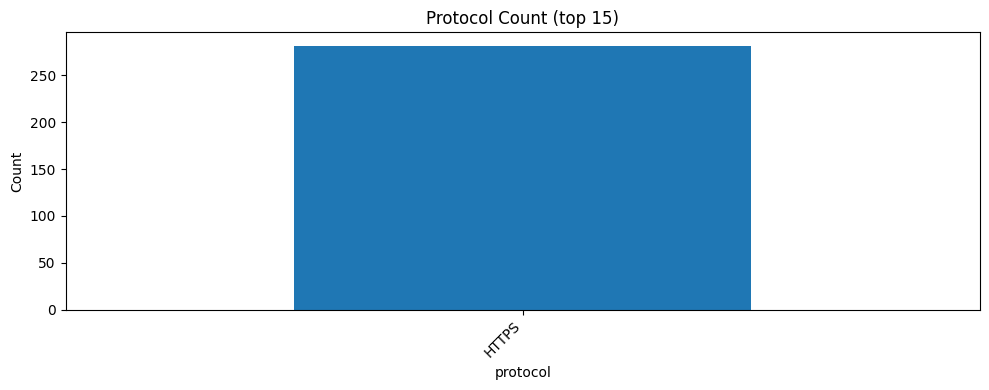

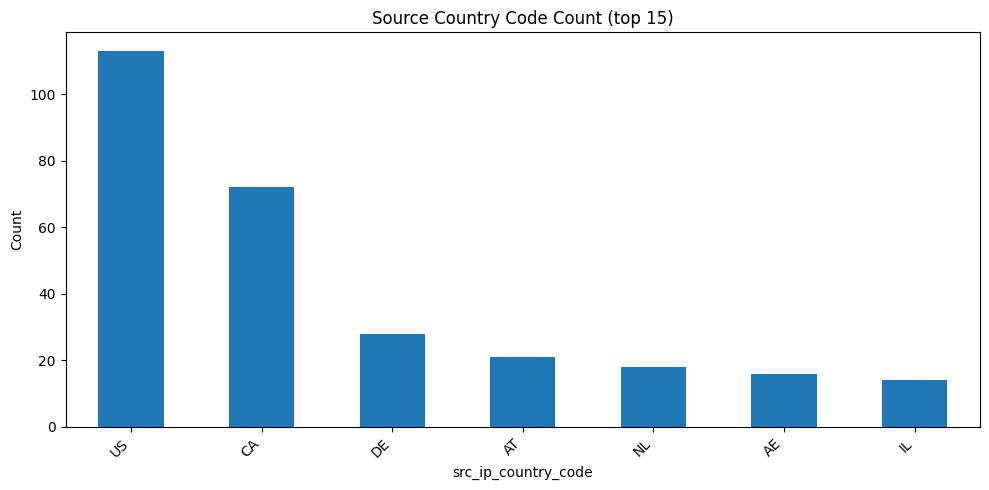

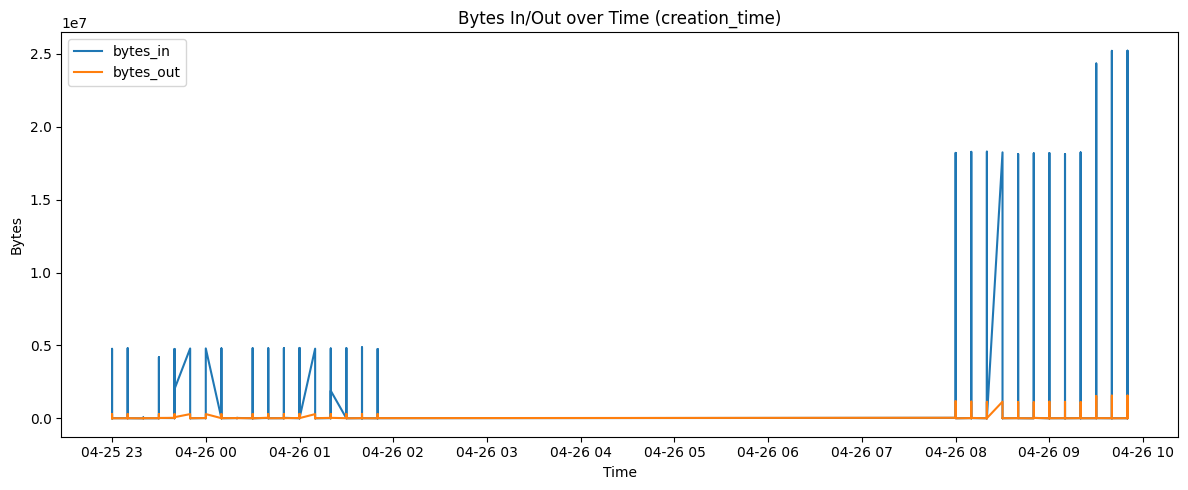

In [14]:

# Histogram for bytes_in / bytes_out
plt.figure(figsize=(10,5))
if "bytes_in" in df.columns:
    plt.hist(df["bytes_in"].dropna(), bins=40, alpha=0.7, label="bytes_in")
if "bytes_out" in df.columns:
    plt.hist(df["bytes_out"].dropna(), bins=40, alpha=0.7, label="bytes_out")
plt.title("Distribution of Bytes In/Out")
plt.xlabel("Bytes")
plt.ylabel("Count")
plt.legend()
plt.show()

# Protocol counts
if "protocol" in df.columns:
    plt.figure(figsize=(10,4))
    df["protocol"].value_counts().head(15).plot(kind="bar")
    plt.title("Protocol Count (top 15)")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Country counts
if "src_ip_country_code" in df.columns:
    plt.figure(figsize=(10,5))
    df["src_ip_country_code"].value_counts().head(15).plot(kind="bar")
    plt.title("Source Country Code Count (top 15)")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Time series: bytes over creation_time
if "creation_time" in df.columns and "bytes_in" in df.columns and "bytes_out" in df.columns:
    ts = df.sort_values("creation_time")
    plt.figure(figsize=(12,5))
    plt.plot(ts["creation_time"], ts["bytes_in"], label="bytes_in")
    plt.plot(ts["creation_time"], ts["bytes_out"], label="bytes_out")
    plt.title("Bytes In/Out over Time (creation_time)")
    plt.xlabel("Time")
    plt.ylabel("Bytes")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Feature Engineering

In [15]:

# session_duration (seconds)
if all(c in df.columns for c in ["end_time", "creation_time"]):
    df["session_duration"] = (df["end_time"] - df["creation_time"]).dt.total_seconds()
else:
    df["session_duration"] = np.nan

# avg_packet_size approximation
for c in ["bytes_in", "bytes_out"]:
    if c not in df.columns:
        df[c] = np.nan
df["total_bytes"] = df["bytes_in"].fillna(0) + df["bytes_out"].fillna(0)
# avoid division by zero
df["avg_packet_size"] = df["total_bytes"] / df["session_duration"].replace({0: np.nan})
df["avg_packet_size"] = df["avg_packet_size"].replace([np.inf, -np.inf], np.nan)

# Optional log features for skewed distributions
for c in ["bytes_in", "bytes_out", "total_bytes", "avg_packet_size", "session_duration"]:
    if c in df.columns:
        df[f"log1p_{c}"] = np.log1p(df[c])

display(df[["bytes_in","bytes_out","session_duration","avg_packet_size","total_bytes"]].head())


,bytes_in,bytes_out,session_duration,avg_packet_size,total_bytes
0,5602,12990,600.0,30.986667,18592
1,30912,18186,600.0,81.830000,49098
2,28506,13468,600.0,69.956667,41974
3,30546,14278,600.0,74.706667,44824
4,6526,13892,600.0,34.030000,20418


## Unsupervised Anomaly Detection — Isolation Forest

anomaly_iforest
Normal        267
Suspicious     15
Name: count, dtype: int64

Sample suspicious rows:


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,...,detection_types,session_duration,total_bytes,avg_packet_size,log1p_bytes_in,log1p_bytes_out,log1p_total_bytes,log1p_avg_packet_size,log1p_session_duration,anomaly_iforest
36,4190330,283456,2024-04-25 23:30:00+00:00,2024-04-25 23:40:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,...,waf_rule,600.0,4473786,7456.310000,15.248290,12.554816,15.313746,8.916950,6.398595,Suspicious
87,1215594,64362,2024-04-26 00:30:00+00:00,2024-04-26 00:40:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,...,waf_rule,600.0,1279956,2133.260000,14.010744,11.072294,14.062337,7.665875,6.398595,Suspicious
116,4827283,306181,2024-04-26 01:00:00+00:00,2024-04-26 01:10:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,...,waf_rule,600.0,5133464,8555.773333,15.389795,12.631935,15.451291,9.054478,6.398595,Suspicious
132,1889834,34306,2024-04-26 01:20:00+00:00,2024-04-26 01:30:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,...,waf_rule,600.0,1924140,3206.900000,14.452000,10.443105,14.469990,8.073372,6.398595,Suspicious
153,4869181,301752,2024-04-26 01:40:00+00:00,2024-04-26 01:50:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,...,waf_rule,600.0,5170933,8618.221667,15.398437,12.617364,15.458564,9.061750,6.398595,Suspicious


Saved: outputs\anomalies.csv


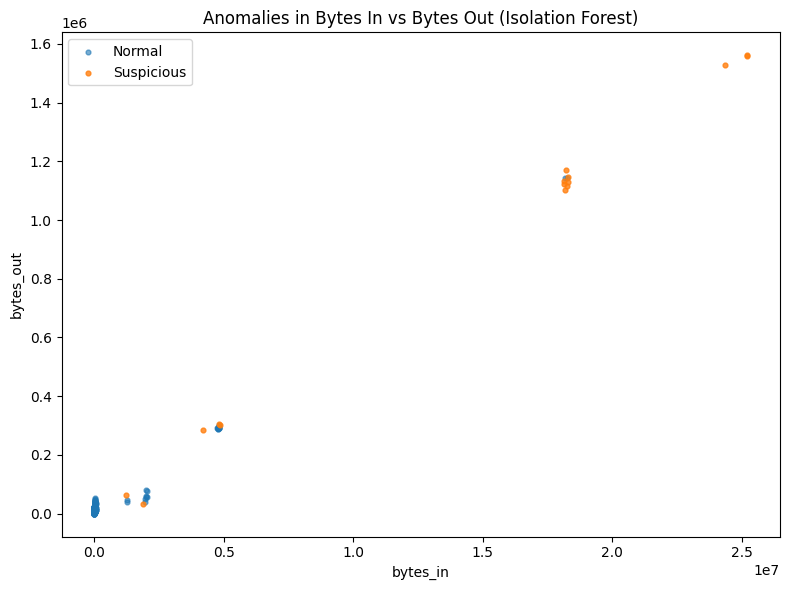

In [16]:

features = []
for c in ["bytes_in","bytes_out","session_duration","avg_packet_size"]:
    if c in df.columns:
        features.append(c)

assert len(features) >= 2, "Need at least 2 numeric features to run Isolation Forest."

X = df[features].copy().fillna(df[features].median())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

iso = IsolationForest(contamination=0.05, random_state=42)
pred = iso.fit_predict(X_scaled)   # -1 = anomaly, 1 = normal
df["anomaly_iforest"] = np.where(pred == -1, "Suspicious", "Normal")

print(df["anomaly_iforest"].value_counts())
anoms = df[df["anomaly_iforest"] == "Suspicious"]
print("\nSample suspicious rows:")
display(anoms.head())

# Save anomalies
anom_csv = os.path.join(OUT_DIR, "anomalies.csv")
anoms.to_csv(anom_csv, index=False)
print("Saved:", anom_csv)

# Visualize bytes_in vs bytes_out with anomaly hue (if both exist)
if "bytes_in" in df.columns and "bytes_out" in df.columns:
    plt.figure(figsize=(8,6))
    normal = df[df["anomaly_iforest"]=="Normal"]
    susp = df[df["anomaly_iforest"]=="Suspicious"]
    plt.scatter(normal["bytes_in"], normal["bytes_out"], s=12, alpha=0.6, label="Normal")
    plt.scatter(susp["bytes_in"],   susp["bytes_out"],   s=12, alpha=0.8, label="Suspicious")
    plt.title("Anomalies in Bytes In vs Bytes Out (Isolation Forest)")
    plt.xlabel("bytes_in"); plt.ylabel("bytes_out")
    plt.legend()
    plt.tight_layout()
    plt.show()


## (Optional) Supervised Classification — RandomForest

Accuracy: 1.0

Classification report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



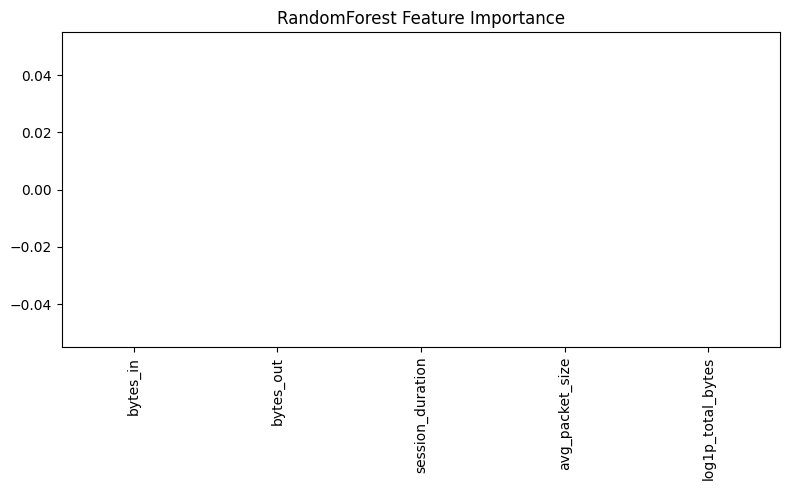

Saved: outputs\rf_feature_importance.png


In [17]:

# We create a proxy label: suspicious = 1 if detection_types == 'waf_rule'
if "detection_types" in df.columns:
    y = (df["detection_types"].astype(str).str.lower() == "waf_rule").astype(int)
    # choose some numeric features
    cand = [c for c in ["bytes_in","bytes_out","session_duration","avg_packet_size","log1p_total_bytes"] if c in df.columns]
    assert len(cand) >= 2, "Need at least 2 numeric features for classification."
    X = df[cand].fillna(df[cand].median())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", round(acc, 4))
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

    # Feature importance
    importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(8,5))
    importances.head(12).plot(kind="bar")
    plt.title("RandomForest Feature Importance")
    plt.tight_layout()
    fig_path = os.path.join(OUT_DIR, "rf_feature_importance.png")
    plt.savefig(fig_path, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved:", fig_path)
else:
    print("Column 'detection_types' not found. Skipping supervised classification.")


## Save a short summary report

In [8]:

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Make plots a bit larger
plt.rcParams["figure.figsize"] = (10, 6)

# Use absolute path instead of relative
DATA_PATH = Path(r"C:\Users\USER\OneDrive\Desktop\Cybersecurity_suspicius_web_Threat\data\CloudWatch_Traffic_Web_Attack.csv")

# Load dataset
df = pd.read_csv(DATA_PATH)

# Show basic info
print("Shape of dataset:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# Save a short summary report
summary = df.describe(include="all")
summary.to_csv("summary_report.csv")
print("\nSummary report saved as 'summary_report.csv'")


Shape of dataset: (282, 16)

First 5 rows:
   bytes_in  bytes_out         creation_time              end_time  \
0      5602      12990  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
1     30912      18186  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
2     28506      13468  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
3     30546      14278  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
4      6526      13892  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   

            src_ip src_ip_country_code protocol  response.code  dst_port  \
0   147.161.161.82                  AE    HTTPS            200       443   
1     165.225.33.6                  US    HTTPS            200       443   
2  165.225.212.255                  CA    HTTPS            200       443   
3   136.226.64.114                  US    HTTPS            200       443   
4   165.225.240.79                  NL    HTTPS            200       443   

         dst_ip              rule_names                      observation_name  